### How to correlate between IF Ab and transcriptome gene signals?




#### This script recreates figure Fig2C in SM-Omics: An automated platform for high-throughput spatial multi-omics; doi: https://doi.org/10.1101/2020.10.14.338418

Notes: \
Ab --> NeuN \
Gene --> Rbfox3

Load libraries

In [1]:
from __future__ import absolute_import, division, print_function
import os
import re
import glob
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import minmax_scale
from scipy.stats import linregress, spearmanr, pearsonr
import numpy as np
import math
import seaborn as sns
from PIL import Image
import math
Image.MAX_IMAGE_PIXELS = 1000000000

%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial',
                           'ps.fonttype':42})

In [ ]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: lambdas_pmeans_genes_NeuN.tsv, lambdas_pmeans_genes_NeuN.tsv, coordinate_registration_NeuN.p
# also download annotation files: 10015CN78*annotations.txt

# mRNA

In [3]:
# Load Lambda pmean df
# Read file
filename = os.path.join(path, 'lambdas_pmeans_genes_NeuN.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

In [4]:
# Change names on genes, ie remove '_'
nwe=[]
nm=lambda_posterior_means.index
for item in nm:
    nwe.append(str(item).split("_")[0])
lambda_posterior_means.index = nwe

# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)


/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [5]:
# Select NeuN gene ie. Rbfox3
pd.set_option('display.max_colwidth', -1)
gene = 'Rbfox3'

# reset index
lambda_gene = lambda_posterior_means.loc[gene, :].to_frame().reset_index()

# Get name of file, for plotting
lambda_gene['name'] = lambda_gene['file'].str.split('/').str[-1].str.split('_stdata').str[0]


/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [6]:
# Scales within each sample
gene_scale = lambda_gene.copy()
gene_scale['Rbfox3.scaled'] = gene_scale.groupby('name')['Rbfox3'].transform(lambda x: minmax_scale(x))

# Ab

In [7]:
# Load Lambda pmean df
# Read file
filename = os.path.join(path, 'lambdas_pmeans_ifs_NeuN.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1])

In [8]:
# Change names on genes, ie remove '_'
nwe=[]
nm=lambda_posterior_means.index
for item in nm:
    nwe.append(str(item).split("_")[0])
lambda_posterior_means.index = nwe

# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = np.exp(lambda_posterior_means-1)


In [9]:
# Select Nestin gene
pd.set_option('display.max_colwidth', -1)
gene = 'Neun'

# reset index
lambda_ab = lambda_posterior_means.loc[gene, :].to_frame().reset_index()

# Get name of file, for plotting
lambda_ab['name'] = lambda_ab['file'].str.split('/').str[-1].str.split('_stdata').str[0]

/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [10]:
# Scales within each sample
abfile_scale = lambda_ab.copy()
abfile_scale['NeuN.scaled'] = abfile_scale.groupby('name')['Neun'].transform(lambda x: minmax_scale(x))

# Annotation

In [11]:
annot_path = path

annot_list = []

for stdata in list(set(abfile_scale['name'].tolist())):
    
    well = stdata.split('_stdata')[0]
    
    filename = os.path.join(annot_path, well + '_annotations.txt')

    annot_file = pd.read_csv(filename, sep = '\t')
    
    # Remove 'Unknown'
    #file = file[file['value'] != 'Unknown']
   
    # Change to int if spot coord are in decimals
    if len(annot_file['x_y'][0].split('.')) == 3: # Spot coord in decimals

        # Detect which delimiter separates the spot coord
        if len(annot_file['x_y'][0].split('_')) == 2:
            delimi = '_'
        elif len(annot_file['x_y'][0].split('x')) == 2:
            delimi = 'x'
        else:
            print('Unknown spot coordinate delimiter.')

        # Round up
        annot_file['x'] = annot_file['x'].round(0)
        annot_file['y'] = annot_file['y'].round(0)

        # Make columns to int type
        annot_file['x'] = annot_file['x'].astype(int)
        annot_file['y'] = annot_file['y'].astype(int)

        # Make columns to string type
        annot_file['x'] = annot_file['x'].astype(str)
        annot_file['y'] = annot_file['y'].astype(str)

        # Make a new columnwith the rounded values
        annot_file['spot_coord'] = annot_file[['x', 'y']].apply(lambda z: '_'.join(z), axis=1)
        annot_file.drop(['x_y'], axis=1, inplace=True)
        annot_file.rename(columns = {'spot_coord':'x_y'}, inplace=True)

    # Keep certain columns:
    annot_file = annot_file.loc[:, ['image', 'x_y', 'value']]
    
    annot_list.append(annot_file)
    
# Concat
annotdf = pd.concat(annot_list)


# Merge gene + ab + annotation

In [12]:
lambdadfTMP = pd.merge(gene_scale, abfile_scale,  how='left', on=['name','coordinate'])
lambdadf = pd.merge(lambdadfTMP, annotdf, how='left', left_on=['name','coordinate'], right_on=['image', 'x_y'])

In [13]:
# Take mean per region per sample
trans = lambdadf.groupby(['name', 'value'])['NeuN.scaled', 'Rbfox3.scaled'].mean()
trans.reset_index(inplace=True)

# Scale min max per sample
trans[['NeuN.norm', 'Rbfox3.norm']] = trans.groupby(['name'])['NeuN.scaled', 'Rbfox3.scaled'].transform(lambda x: minmax_scale(x))
trans = trans.dropna(axis=0, how='any')

# selectes 3 samples
trans = trans[trans.name.isin(['10015CN78_D2', '10015CN78_E1','10015CN78_E2'])]

/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Spearman's r: 0.709
Spearman's p value: 0.0004600341132595013


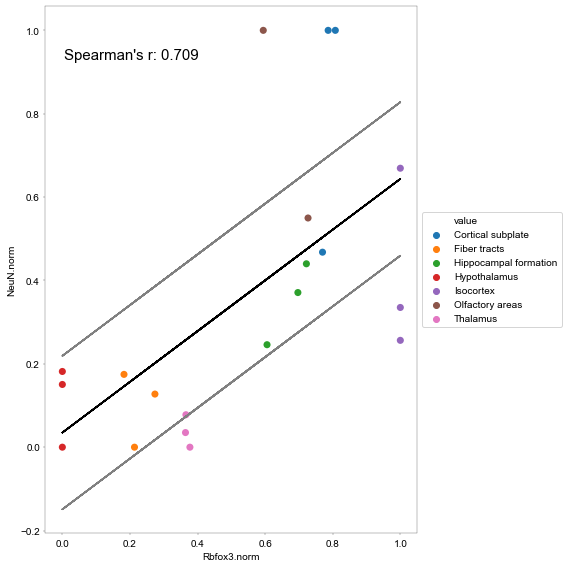

In [14]:
# Plot

# initialize a figure
fig, ax = plt.subplots(figsize=(8, 8))

x = 'Rbfox3.norm'
y = 'NeuN.norm'
hue = 'value'
style = 'name'

sns.scatterplot(x=x, y=y, data=trans, ax=ax, hue=hue, s=50, linewidth=0)

# Calculate the linear regression
slope, intercept, r_value, p_value, std_err = linregress(trans[x], trans[y])

coef = np.polyfit(trans[x],trans[y],1)
poly1d_fn = np.poly1d(coef)
ax.plot(trans[x], poly1d_fn(trans[x]), c="k")
ax.plot(trans[x], poly1d_fn(trans[x])+std_err, c="grey")
ax.plot(trans[x], poly1d_fn(trans[x])-std_err, c="grey")
#ax.errorbar(trans[x], poly1d_fn(trans[x]), yerr=poly1d_fn(trans[x]) - trans[y], fmt='.k')

# Spearman's & Pearson's r
spear, pspear = spearmanr(trans[x], trans[y])
pear, p = pearsonr(trans[x], trans[y])
print("Spearman's r: " + str(round(spear, 3)))
print("Spearman's p value: " + str(pspear))
ax.text(0.05, 0.9, "Spearman's r: " + str(round(spear, 3)), transform=ax.transAxes, fontsize=15)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#plt.savefig("IFvsGENE_Neun.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200, rasterized=True)

# Plotting overlaps

In [15]:
# Load registration file
reg_file = os.path.join(path, 'coordinate_registration_NeuN.p')
registered_coordinates_dict = pickle.load(open(reg_file,'rb'), encoding='bytes') 

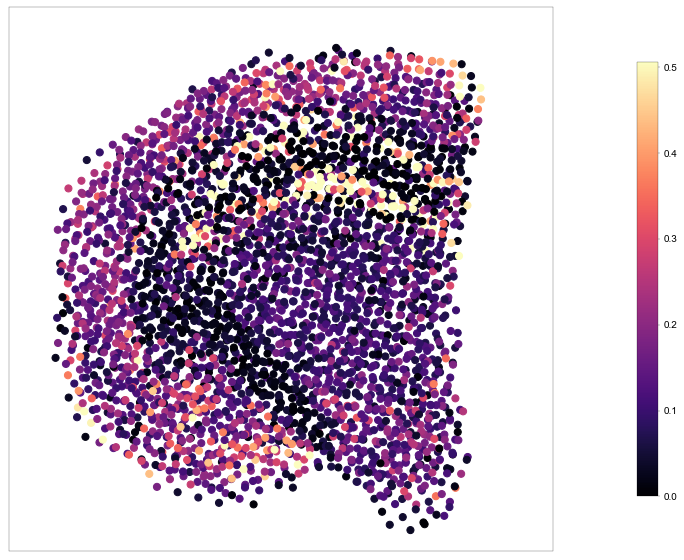

In [16]:
#Plotting overlapping ab
# Path can be found in registration coordinate file
coord_path = os.path.dirname(list(registered_coordinates_dict)[0])
variables_of_interest = ['M1']

# use the same color scale across the arrays
vmin,vmax = 0,np.percentile(abfile_scale['NeuN.scaled'].values,97)


# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(30, 10))

# initialize axes
ax = []
for row_idx in range(0,1):
    for col_idx in range(0,1):
        axes = plt.subplot2grid((1, 1), (row_idx, col_idx))
        ax.append(axes) 

# adjust the axes
for ax_idx in range(0,len(ax)):
    
    ax[ax_idx].set_aspect('equal')
    
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    
    ax[ax_idx].set_xlim([-18,18])
    ax[ax_idx].set_ylim([-18,18])

cbmap = [None for _ in range(0,len(ax))]
    
# loop over the count files
for sample, group in abfile_scale.groupby('name'):
    
    count_file = os.path.join(coord_path, sample + '_stdata_adjusted.tsv')
    
    # for each ST spot on the array, let us get its registered coordinate if available
    coordinates_found = np.zeros(len(group['coordinate'].tolist())) # indicator of being registered
    coordinates = []  
    for coord_idx,coordinate in enumerate(group['coordinate'].tolist()):
        if coordinate in registered_coordinates_dict[count_file]:
            coordinates_found[coord_idx] = 1
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = np.array(coordinates)
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    # rotate
    alpha = 160
    x_coor_rot = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
    y_coor_rot = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates 
    
    # visualize the registered ST spots
    cbmap[ax_idx] = ax[ax_idx].scatter(x_coor_rot,y_coor_rot,
                               s=50, c=group['NeuN.scaled'][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o') 

# add colorbars
for ax_idx in range(0,len(ax)):
    if cbmap[ax_idx] is not None:
        cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=ax[ax_idx],shrink=0.8)    
       
        
#plt.savefig("Neun_IF_overlap.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200, rasterized=True) 

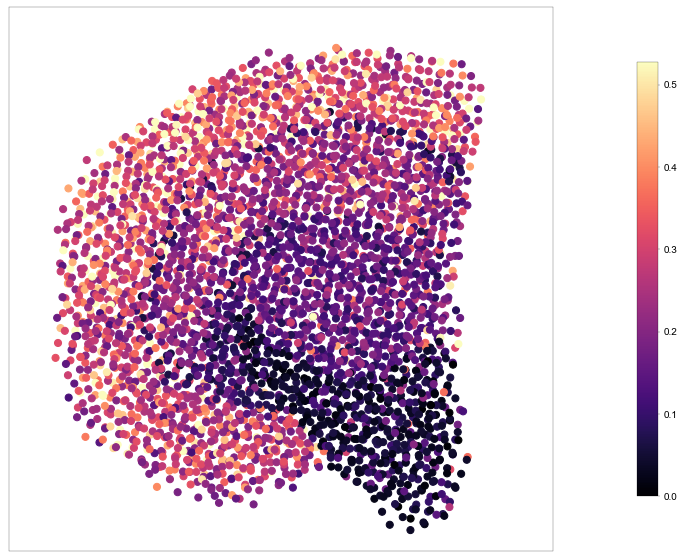

In [17]:
#Plotting overlapping ab
# Path can be found in registration coordinate file
coord_path = os.path.dirname(list(registered_coordinates_dict)[0])
variables_of_interest = ['M1']

# use the same color scale across the arrays
vmin,vmax = 0,np.percentile(gene_scale['Rbfox3.scaled'].values,96)

# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(30, 10))

# initialize axes
ax = []
for row_idx in range(0,1):
    for col_idx in range(0,1):
        axes = plt.subplot2grid((1, 1), (row_idx, col_idx))
        ax.append(axes) 

# adjust the axes
for ax_idx in range(0,len(ax)):
    
    ax[ax_idx].set_aspect('equal')
    
    ax[ax_idx].set_xticks([])
    ax[ax_idx].set_yticks([])
    
    ax[ax_idx].set_xlim([-18,18])
    ax[ax_idx].set_ylim([-18,18])

cbmap = [None for _ in range(0,len(ax))]
    
# loop over the count files
for sample, group in gene_scale.groupby('name'):
    
    count_file = os.path.join(coord_path, sample + '_stdata_adjusted.tsv')
    
    # for each ST spot on the array, let us get its registered coordinate if available
    coordinates_found = np.zeros(len(group['coordinate'].tolist())) # indicator of being registered
    coordinates = []  
    for coord_idx,coordinate in enumerate(group['coordinate'].tolist()):
        if coordinate in registered_coordinates_dict[count_file]:
            coordinates_found[coord_idx] = 1
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = np.array(coordinates)
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    # rotate
    alpha = 160
    x_coor_rot = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
    y_coor_rot = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates 
    
    # visualize the registered ST spots
    cbmap[ax_idx] = ax[ax_idx].scatter(x_coor_rot,y_coor_rot,
                               s=50, c=group['Rbfox3.scaled'][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o') 

# add colorbars
for ax_idx in range(0,len(ax)):
    if cbmap[ax_idx] is not None:
        cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=ax[ax_idx],shrink=0.8)           
        
#plt.savefig("Neun_gene_overlap.pdf", transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200, rasterized=True) 